In [ ]:
!pip install pandas torch transformers scikit-learn optuna tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
import logging
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving financial_data.csv to financial_data (1).csv


In [ ]:
# Load and preprocess data
correct_data = pd.read_csv('financial_data.csv')

# Display the DataFrame
correct_data.head()

# Print all column names
print("Columns in the DataFrame:", correct_data.columns)

# Ensure the Date column is correctly parsed and available
if 'Date' in correct_data.columns:
    # Convert the 'Date' column to datetime
    correct_data['Date'] = pd.to_datetime(correct_data['Date'], errors='coerce')

    # Check for rows with NaT dates and drop them
    correct_data.dropna(subset=['Date'], inplace=True)

    # Print the first few rows to verify
    print("Data with Date column:")
    print(correct_data.head())

# Strip leading and trailing spaces from column names
correct_data.columns = correct_data.columns.str.strip()

# Preprocess the data
correct_data['Date'] = pd.to_datetime(correct_data['Date'], format='%Y-%m-%d', errors='raise')
# Do not set 'Date' as the index if you need it as a column later
correct_data['text'] = correct_data['text'].astype(str).fillna('')

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the FinBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

def tokenize_function(texts):
    # Tokenize the input text
    tokens = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'  # Return PyTorch tensors directly
    )
    return tokens

# Use the correct column name for your labels
label_column_name = 'label'  # Update this to match your actual DataFrame's column name for labels

# Tokenize the entire dataset
tokenized_data = tokenize_function(correct_data['text'].tolist())

# Add tokenized data to the DataFrame
correct_data['input_ids'] = [ids.numpy().tolist() for ids in tokenized_data['input_ids']]
correct_data['attention_mask'] = [mask.numpy().tolist() for mask in tokenized_data['attention_mask']]

# Ensure labels are integers and either 0 or 1
correct_data['label'] = correct_data['label'].astype(int)
print("Unique labels in the dataset:", correct_data['label'].unique())

# Reset the index to include 'Date' as a column again for splitting
correct_data.reset_index(drop=True, inplace=True)

# Ensure the Date column is still in the DataFrame
if 'Date' not in correct_data.columns:
    raise KeyError("The 'Date' column is missing after resetting the index.")

# Split data into training (70%), validation (15%), and test (15%) sets chronologically
train_data, temp_data = train_test_split(correct_data, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

# Display the split to ensure it is chronological
print(f"Training data: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Validation data: {val_data['Date'].min()} to {val_data['Date'].max()}")
print(f"Test data: {test_data['Date'].min()} to {test_data['Date'].max()}")

def prepare_tensors(data):
    input_ids = torch.tensor(data['input_ids'].tolist(), dtype=torch.long)
    attention_masks = torch.tensor(data['attention_mask'].tolist(), dtype=torch.long)
    labels = torch.tensor(data['label'].values, dtype=torch.long)  # Ensure labels are 0 and 1 for binary classification
    return TensorDataset(input_ids, attention_masks, labels)

# Example of checking data integrity
print("Sample input_ids:", correct_data['input_ids'].head())
print("Sample attention_mask:", correct_data['attention_mask'].head())
print("Sample labels:", correct_data['label'].head())

# Create DataLoaders
def create_dataloader(dataset, batch_size, sampler):
    return DataLoader(dataset, sampler=sampler(dataset), batch_size=batch_size, num_workers=2, pin_memory=True)

# Define objective function for Optuna with early stopping
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    train_dataset = prepare_tensors(train_data)
    val_dataset = prepare_tensors(val_data)

    train_dataloader = create_dataloader(train_dataset, batch_size, SequentialSampler)
    val_dataloader = create_dataloader(val_dataset, batch_size, SequentialSampler)

    # Initialize model with mismatched sizes allowed
    model = BertForSequenceClassification.from_pretrained(
        'yiyanghkust/finbert-tone',
        num_labels=2,
        ignore_mismatched_sizes=True
    )
    model.to(device)

    # Reinitialize the classifier layer to match the new number of labels
    model.classifier = torch.nn.Linear(model.config.hidden_size, 2)  # Ensure it is set for binary classification
    model.config.num_labels = 2  # Ensure the model's config is updated

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader))

    # Use AMP for mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_f1 = 0
    patience_counter = 0

    # Training loop with early stopping
    model.train()
    for epoch in range(50):
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
            model.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        # Validation
        model.eval()
        val_predictions, val_true_labels = [], []
        for batch in val_dataloader:
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_true_labels.extend(b_labels.cpu().numpy())

        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        logger.info(f'Epoch {epoch + 1}, Validation F1: {val_f1:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Check for early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                logger.info("Early stopping")
                break

    return best_val_f1

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)



Columns in the DataFrame: Index(['Date', 'label', 'text'], dtype='object')
Data with Date column:
        Date  label                                               text
0 2024-07-06      1  world bank mandates hire security consultant b...
1 2024-06-06      0  afrexim bank disburse another million nnpc bil...
2 2024-05-06      1  executive order tinubu stop payment taxes levi...
3 2024-04-06      0  market loses n billion investors offload stock...
4 2024-03-06      0  ngx reacts bearishly strike action market decl...


[I 2024-08-12 02:48:51,911] A new study created in memory with name: no-name-96597bbe-48fc-45db-bd50-227117f9d510


Unique labels in the dataset: [1 0]
Training data: 2014-01-07 00:00:00 to 2024-12-04 00:00:00
Validation data: 2012-01-06 00:00:00 to 2014-12-03 00:00:00
Test data: 2010-01-02 00:00:00 to 2012-12-01 00:00:00
Sample input_ids: 0    [3, 907, 230, 12424, 4761, 501, 8189, 227, 189...
1    [3, 18058, 3124, 5064, 230, 17127, 796, 27, 18...
2    [3, 577, 440, 8947, 7986, 2096, 4001, 475, 523...
3    [3, 52, 21471, 2501, 227, 311, 951, 14941, 924...
4    [3, 7369, 456, 6356, 63, 20534, 724, 5564, 132...
Name: input_ids, dtype: object
Sample attention_mask: 0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: attention_mask, dtype: object
Sample labels: 0    1
1    0
2    1
3    0
4    0
Name: label, dtype: int64


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 6: 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]
[I 2024-08-12 02:49:44,149] Trial 0 finished with value: 0.7091497217845062 and parameters: {'learning_rate': 4.5576656796210855e-05, 'batch_size': 32}. Best is trial 0 with value: 0.7091497217845062.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found

Best hyperparameters: {'learning_rate': 3.564937469182303e-05, 'batch_size': 16}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50


Training Epoch 1: 100%|██████████| 61/61 [00:07<00:00,  7.78it/s]


Epoch 1 completed with Training Loss: 0.6673, Training Accuracy: 0.6332


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]


Epoch 1 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Model saved.
Epoch 2/50


Training Epoch 2: 100%|██████████| 61/61 [00:08<00:00,  7.61it/s]


Epoch 2 completed with Training Loss: 0.5560, Training Accuracy: 0.7449


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.91it/s]


Epoch 2 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Epoch 3/50


Training Epoch 3: 100%|██████████| 61/61 [00:07<00:00,  7.71it/s]


Epoch 3 completed with Training Loss: 0.5516, Training Accuracy: 0.7490


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.78it/s]


Epoch 3 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Epoch 4/50


Training Epoch 4: 100%|██████████| 61/61 [00:08<00:00,  7.54it/s]


Epoch 4 completed with Training Loss: 0.5646, Training Accuracy: 0.7377


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s]


Epoch 4 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Epoch 5/50


Training Epoch 5: 100%|██████████| 61/61 [00:08<00:00,  7.57it/s]


Epoch 5 completed with Training Loss: 0.5630, Training Accuracy: 0.7418


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s]


Epoch 5 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Epoch 6/50


Training Epoch 6: 100%|██████████| 61/61 [00:07<00:00,  7.66it/s]


Epoch 6 completed with Training Loss: 0.5612, Training Accuracy: 0.7469


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.72it/s]


Epoch 6 Validation Loss: 0.5846, Validation Accuracy: 0.7129
Early stopping triggered.


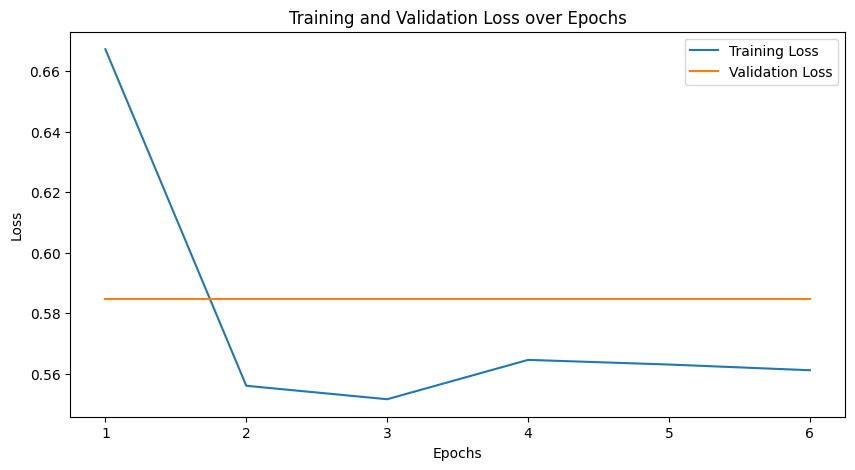

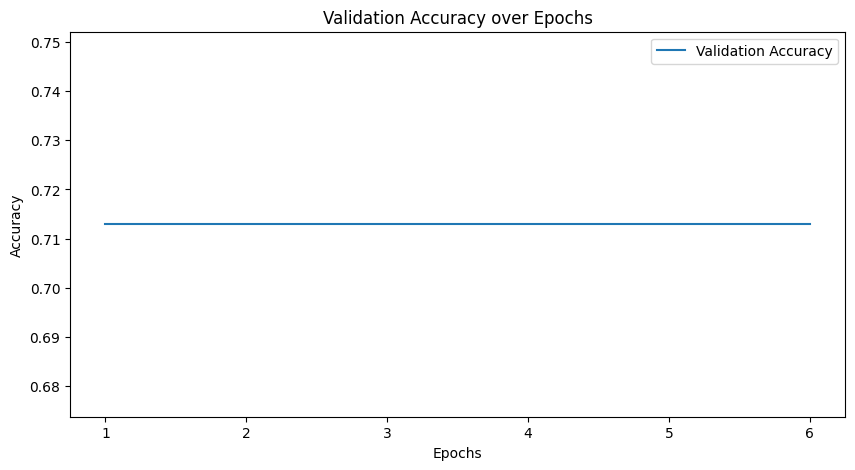

Testing: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


ROC AUC Score: 0.6559
Test Accuracy: 0.6333
Test F1 Score: 0.6330
Test Precision: 0.6376
Test Recall: 0.6333
Test ROC AUC: 0.6559


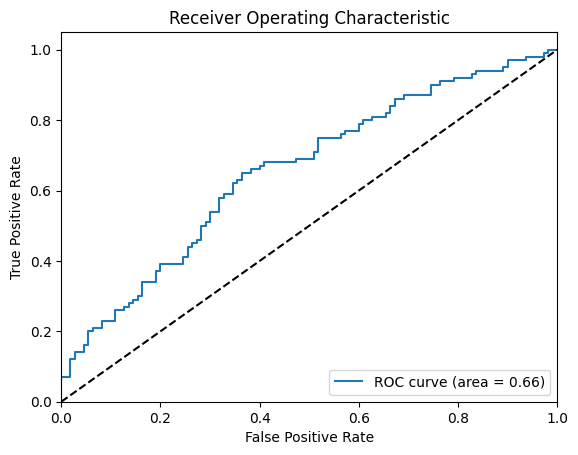

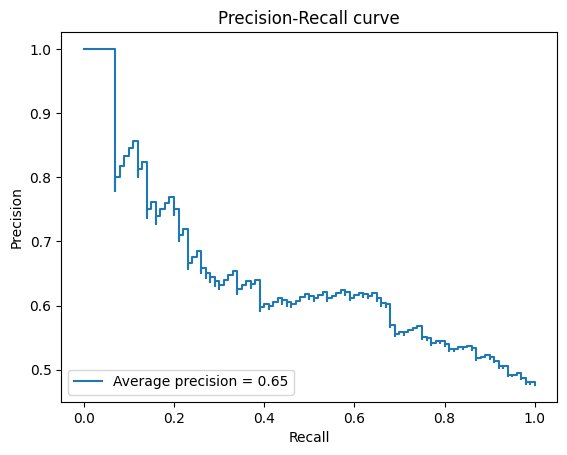

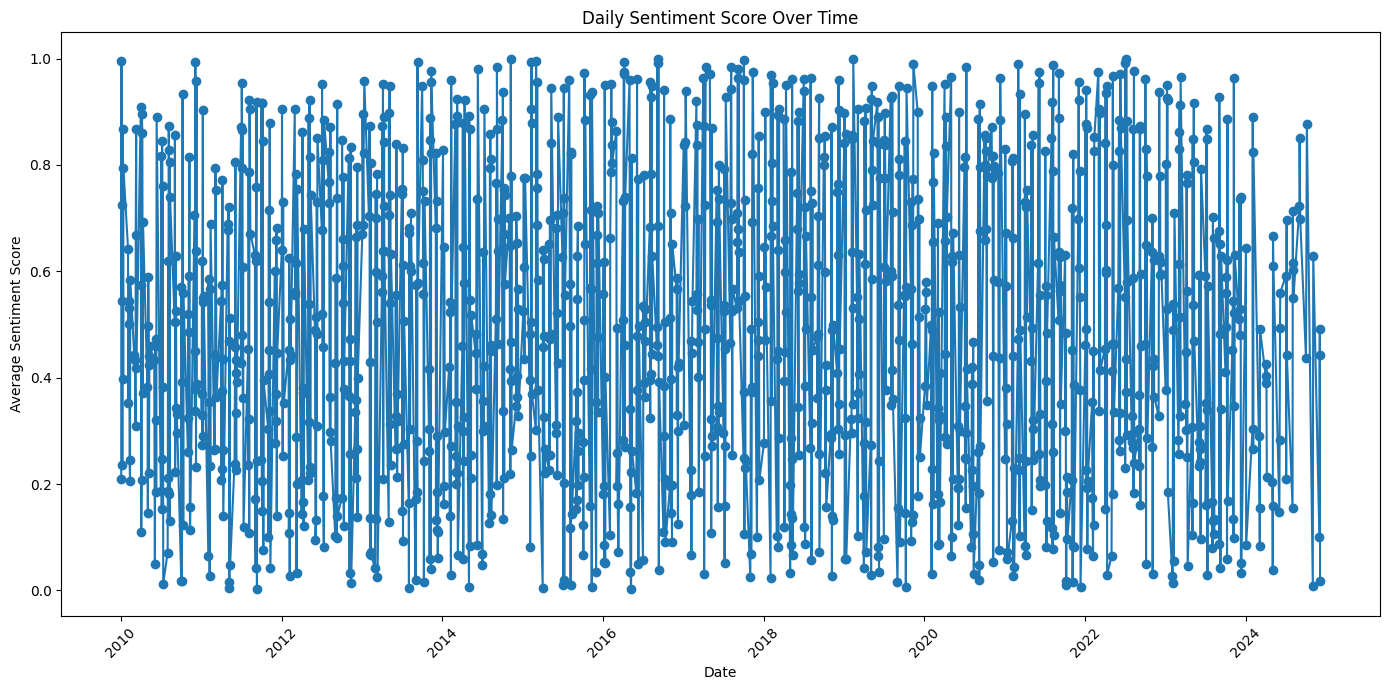

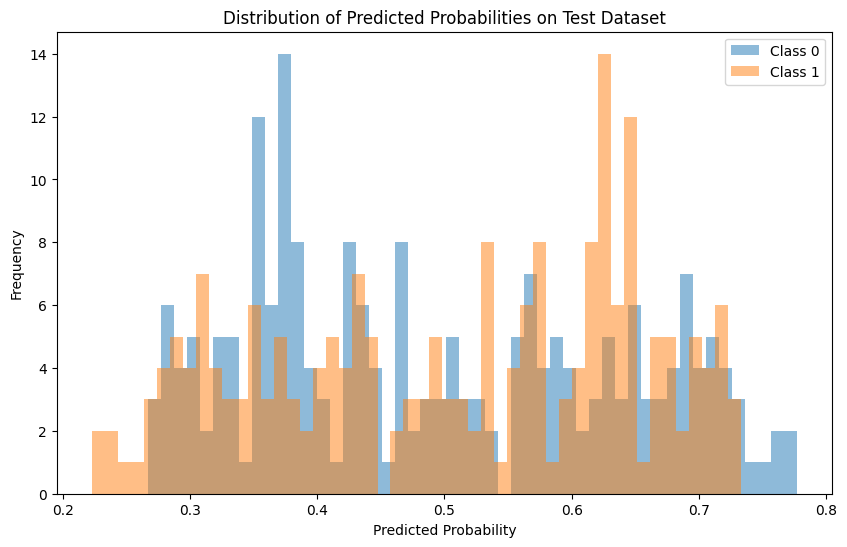

In [ ]:
# Best hyperparameters
best_params = study.best_params
logger.info(f'Best hyperparameters: {best_params}')
print(f'Best hyperparameters: {best_params}')

# Final training with both training and validation datasets
def final_training():
    train_dataset = prepare_tensors(train_data)
    val_dataset = prepare_tensors(val_data)

    train_dataloader = create_dataloader(train_dataset, best_params['batch_size'], SequentialSampler)
    val_dataloader = create_dataloader(val_dataset, best_params['batch_size'], SequentialSampler)

    model = BertForSequenceClassification.from_pretrained(
        'yiyanghkust/finbert-tone',
        num_labels=2,
        ignore_mismatched_sizes=True
    )
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=best_params['learning_rate'], eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader))

    scaler = torch.cuda.amp.GradScaler()

    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    model.train()
    for epoch in range(50):
        print(f"Epoch {epoch + 1}/{50}")
        total_loss, total_accuracy = 0, 0

        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
            model.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).flatten()
            total_accuracy += (preds == b_labels).cpu().numpy().mean()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = total_accuracy / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print(f'Epoch {epoch + 1} completed with Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}')

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds, val_true = [], []

        for batch in tqdm(val_dataloader, desc="Validation"):
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                logits = outputs.logits
                val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
                val_true.extend(b_labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Early stopping based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'final_model.pt')
            print("Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        model.train()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot validation accuracy over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    return model

final_model = final_training()

# Test evaluation function
def evaluate_test_data(model, test_data):
    test_dataset = prepare_tensors(test_data)
    test_dataloader = create_dataloader(test_dataset, best_params['batch_size'], SequentialSampler)

    model.eval()

    test_predictions, test_true_labels, test_probs = [], [], []

    for batch in tqdm(test_dataloader, desc="Testing"):
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask)

        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

        preds = np.argmax(probs, axis=1)

        test_predictions.extend(preds)
        test_true_labels.extend(b_labels.cpu().numpy())
        test_probs.extend(probs)

    return test_probs, test_true_labels, test_predictions

# Call the evaluation function to populate test_probs and test_true_labels
test_probs, test_true_labels, test_predictions = evaluate_test_data(final_model, test_data)

# Calculate evaluation metrics using test_predictions
accuracy = accuracy_score(test_true_labels, test_predictions)
f1 = f1_score(test_true_labels, test_predictions, average='weighted')
precision = precision_score(test_true_labels, test_predictions, average='weighted')
recall = recall_score(test_true_labels, test_predictions, average='weighted')
roc_auc = roc_auc_score(test_true_labels, [p[1] for p in test_probs])
print(f'ROC AUC Score: {roc_auc:.4f}')

logger.info(f'Test Accuracy: {accuracy:.4f}')
logger.info(f'Test F1 Score: {f1:.4f}')
logger.info(f'Test Precision: {precision:.4f}')
logger.info(f'Test Recall: {recall:.4f}')
logger.info(f'Test ROC AUC: {roc_auc:.4f}')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test ROC AUC: {roc_auc:.4f}')

def plot_auc_roc_curve(true_labels, probs):
    fpr, tpr, _ = roc_curve(true_labels, [p[1] for p in probs])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(true_labels, probs):
    precision, recall, _ = precision_recall_curve(true_labels, [p[1] for p in probs])
    average_precision = average_precision_score(true_labels, [p[1] for p in probs])

    plt.figure()
    plt.step(recall, precision, where='post', label=f'Average precision = {average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plot_daily_sentiment_score(data):
    if 'Date' not in data.columns or 'sentiment_score' not in data.columns:
        raise ValueError("Data must contain 'Date' and 'sentiment_score' columns.")

    daily_sentiment = data.groupby('Date').agg({'sentiment_score': 'mean'}).reset_index()

    plt.figure(figsize=(14, 7))
    plt.plot(daily_sentiment['Date'], daily_sentiment['sentiment_score'], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.title('Daily Sentiment Score Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_probability_distribution(probs):
    plt.figure(figsize=(10, 6))
    for i in range(2):
        plt.hist([p[i] for p in probs], bins=50, alpha=0.5, label=f'Class {i}')

    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities on Test Dataset')
    plt.legend(loc='upper right')
    plt.show()

# Visualizations
plot_auc_roc_curve(test_true_labels, test_probs)
plot_precision_recall_curve(test_true_labels, test_probs)
# Example data with sentiment_score for visualization purposes
correct_data['sentiment_score'] = np.random.rand(len(correct_data))  # Dummy sentiment scores
plot_daily_sentiment_score(correct_data)
plot_probability_distribution(test_probs)
